In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel
import argparse
import time
import timm.optim.optim_factory as optim_factory
import datetime
import matplotlib.pyplot as plt
import wandb
import copy

# from config import Config_MBM_SPIKE
from config import Config_MBM_fMRI
from dataset import allen_dataset_1d, allen_dataset_2d
# from sc_mbm.mae_for_spike_train import MAEforSPIKE, spike_encoder
from sc_mbm.mae_for_fmri import MAEforFMRI, fmri_encoder
# from sc_mbm.trainer import train_one_epoch_spike
from sc_mbm.trainer import train_one_epoch
from sc_mbm.trainer import NativeScalerWithGradNormCount as NativeScaler
from sc_mbm.utils import save_model

In [2]:
os.environ["WANDB_START_METHOD"] = "thread"
os.environ['WANDB_DIR'] = "."

class wandb_logger:
    def __init__(self, config):
        wandb.init(
                    project="mind-vis",
                    anonymous="allow",
                    group='stageA_sc-mbm',
                    config=config,
                    reinit=True)

        self.config = config
        self.step = None
    
    def log(self, name, data, step=None):
        if step is None:
            wandb.log({name: data})
        else:
            wandb.log({name: data}, step=step)
            self.step = step
    
    def watch_model(self, *args, **kwargs):
        wandb.watch(*args, **kwargs)

    def log_image(self, name, fig):
        if self.step is None:
            wandb.log({name: wandb.Image(fig)})
        else:
            wandb.log({name: wandb.Image(fig)}, step=self.step)

    def finish(self):
        wandb.finish(quiet=True)

In [3]:
def create_readme(config, path):
    print(config.__dict__)
    with open(os.path.join(path, 'README.md'), 'w+') as f:
        print(config.__dict__, file=f)

In [4]:
def fmri_transform(x, sparse_rate=0.2):
    # x: 1, num_voxels
    x_aug = copy.deepcopy(x)
    idx = np.random.choice(x.shape[0], int(x.shape[0]*sparse_rate), replace=False)
    x_aug[idx] = 0
    return torch.FloatTensor(x_aug)

In [5]:
# config = Config_MBM_SPIKE()
config = Config_MBM_fMRI()
config = torch.load('../results/spike_pretrain/02-12-2024-12-36-41/checkpoints/checkpoint.pth')['config']

/scratch/1006529/ipykernel_935125/2604286748.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  config = torch.load('../results/spike_pretrain/02-12-2024-12-36-41/checkpoin

In [6]:
config.root_path

'../'

In [7]:
if torch.cuda.device_count() > 1:
    torch.cuda.set_device(config.local_rank) 
    torch.distributed.init_process_group(backend='nccl')
output_path = os.path.join(config.root_path, 'results', 'spike_pretrain',  '%s'%(datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")))
# output_path = os.path.join(config.root_path, 'results', 'fmri_pretrain')
config.output_path = output_path
logger = wandb_logger(config) if config.local_rank == 0 else None

if config.local_rank == 0:
    os.makedirs(output_path, exist_ok=True)
    create_readme(config, output_path)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: zhaizhongyuan (11785-bhiksha). Use `wandb login --relogin` to force relogin


{'lr': 0.00025, 'min_lr': 0.0, 'weight_decay': 0.05, 'num_epoch': 300, 'warmup_epochs': 40, 'batch_size': 32, 'clip_grad': 0.8, 'mask_ratio': 0.75, 'patch_size': 8, 'embed_dim': 128, 'decoder_embed_dim': 512, 'depth': 24, 'num_heads': 16, 'decoder_num_heads': 16, 'mlp_ratio': 1.0, 'root_path': '../', 'output_path': '../results/spike_pretrain/03-12-2024-09-14-41', 'seed': 2022, 'roi': 'VC', 'aug_times': 1, 'num_sub_limit': None, 'include_hcp': True, 'include_kam': True, 'accum_iter': 1, 'use_nature_img_loss': False, 'img_recon_weight': 0.5, 'focus_range': None, 'focus_rate': 0.6, 'local_rank': 0}


In [8]:
device = torch.device(f'cuda:{config.local_rank}') if torch.cuda.is_available() else torch.device('cpu')
torch.manual_seed(config.seed)
np.random.seed(config.seed)

In [9]:
config.root_path = '../'

In [10]:
# create dataset and dataloader
# allen_dataset = allen_dataset_1d(fmri_transform=fmri_transform)
allen_dataset = allen_dataset_1d()

print(f'Dataset size: {len(allen_dataset)}\nNumber of neurons: {allen_dataset.n_neurons}')
sampler = torch.utils.data.DistributedSampler(allen_dataset, rank=config.local_rank) if torch.cuda.device_count() > 1 else None 

dataloader_allen = DataLoader(allen_dataset, batch_size=config.batch_size, sampler=sampler, 
            shuffle=(sampler is None), pin_memory=True)

Dataset size: 5900
Number of neurons: 896


In [11]:
allen_dataset[0]['spikes'].shape

torch.Size([1, 896])

Text(0, 0.5, 'Spike counts')

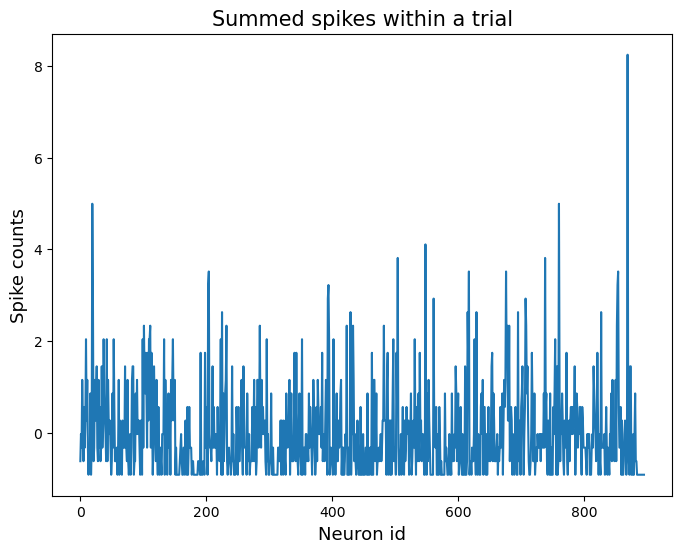

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(allen_dataset[0]['spikes'].flatten())), allen_dataset[0]['spikes'].flatten())
plt.title('Summed spikes within a trial', fontsize=15)
plt.xlabel('Neuron id', fontsize=13)
plt.ylabel('Spike counts', fontsize=13)

In [13]:
allen_dataset_2 = allen_dataset_2d()

In [14]:
allen_dataset_2[0]['spikes'].shape

torch.Size([1, 899, 250])

Text(0, 0.5, 'Neuron id')

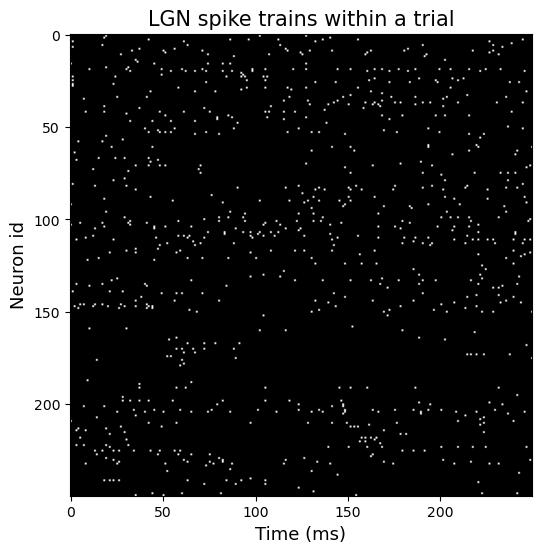

In [36]:
plt.figure(figsize=(8, 6))
plt.imshow(allen_dataset_2[0]['spikes'][0][:250, :], cmap='gray')
plt.title('LGN spike trains within a trial', fontsize=15)
plt.xlabel('Time (ms)', fontsize=13)
plt.ylabel('Neuron id', fontsize=13)

In [34]:
# create model
# config.num_voxels = allen_dataset.n_neurons
# model = MAEforSPIKE(img_size=allen_dataset.n_neurons, patch_size=config.patch_size, embed_dim=config.embed_dim,
#                 decoder_embed_dim=config.decoder_embed_dim, depth=config.depth, 
#                 num_heads=config.num_heads, decoder_num_heads=config.decoder_num_heads, mlp_ratio=config.mlp_ratio,
#                 focus_range=config.focus_range, focus_rate=config.focus_rate, 
#                 img_recon_weight=config.img_recon_weight, use_nature_img_loss=config.use_nature_img_loss)
model = MAEforFMRI(num_voxels=allen_dataset.n_neurons, patch_size=config.patch_size, embed_dim=config.embed_dim,
                decoder_embed_dim=config.decoder_embed_dim, depth=config.depth, 
                num_heads=config.num_heads, decoder_num_heads=config.decoder_num_heads, mlp_ratio=config.mlp_ratio,
                focus_range=config.focus_range, focus_rate=config.focus_rate, 
                img_recon_weight=config.img_recon_weight, use_nature_img_loss=config.use_nature_img_loss)
model.to(device)
model_without_ddp = model
if torch.cuda.device_count() > 1:
    model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)
    model = DistributedDataParallel(model, device_ids=[config.local_rank], output_device=config.local_rank, find_unused_parameters=config.use_nature_img_loss)

param_groups = optim_factory.add_weight_decay(model, config.weight_decay)
optimizer = torch.optim.AdamW(param_groups, lr=config.lr, betas=(0.9, 0.95))
print(optimizer)
loss_scaler = NativeScaler()

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.00025
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.00025
    maximize: False
    weight_decay: 0.05
)


In [28]:
if logger is not None:
    logger.watch_model(model,log='all', log_freq=1000)

cor_list = []
start_time = time.time()
print('Start Training the spike MAE ... ...')
img_feature_extractor = None
preprocess = None
if config.use_nature_img_loss:
    from torchvision.models import resnet50, ResNet50_Weights
    from torchvision.models.feature_extraction import create_feature_extractor
    weights = ResNet50_Weights.DEFAULT
    preprocess = weights.transforms()
    m = resnet50(weights=weights)   
    img_feature_extractor = create_feature_extractor(m, return_nodes={f'layer2': 'layer2'}).to(device).eval()
    for param in img_feature_extractor.parameters():
        param.requires_grad = False

NameError: name 'logger' is not defined

In [29]:
@torch.no_grad()
def plot_recon_figures(model, device, dataset, output_path, num_figures = 5, config=None, logger=None, model_without_ddp=None):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    model.eval()
    fig, axs = plt.subplots(num_figures, 3, figsize=(30,15))
    fig.tight_layout()
    axs[0,0].set_title('Ground-truth')
    axs[0,1].set_title('Masked Ground-truth')
    axs[0,2].set_title('Reconstruction')

    for ax in axs:
        sample = next(iter(dataloader))['spikes']
        sample = sample.to(device)
        _, pred, mask = model(sample, mask_ratio=config.mask_ratio)
        sample_with_mask = model_without_ddp.patchify(sample).to('cpu').numpy().reshape(-1, model_without_ddp.patch_size)
        pred = model_without_ddp.unpatchify(pred).to('cpu').numpy().reshape(-1)
        sample = sample.to('cpu').numpy().reshape(-1)
        mask = mask.to('cpu').numpy().reshape(-1)
        # cal the cor
        cor = np.corrcoef([pred, sample])[0,1]

        x_axis = np.arange(0, sample.shape[-1])
        # groundtruth
        ax[0].plot(x_axis, sample)
        # groundtruth with mask
        s = 0
        for x, m in zip(sample_with_mask,mask):
            if m == 0:
                ax[1].plot(x_axis[s:s+len(x)], x, color='#1f77b4')
            s += len(x)
        # pred
        ax[2].plot(x_axis, pred)
        ax[2].set_ylabel('cor: %.4f'%cor, weight = 'bold')
        ax[2].yaxis.set_label_position("right")

    fig_name = 'reconst-%s'%(datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))
    fig.savefig(os.path.join(output_path, f'{fig_name}.png'))
    if logger is not None:
        logger.log_image('reconst', fig)
    plt.close(fig)

def update_config(args, config):
    for attr in config.__dict__:
        if hasattr(args, attr):
            if getattr(args, attr) != None:
                setattr(config, attr, getattr(args, attr))
    return config

In [30]:
allen_dataset[0]['spikes'].shape

torch.Size([1, 896])

In [31]:
allen_dataset[0]['image'].shape

torch.Size([256, 256, 3])

In [32]:
config.num_epoch = 300

In [16]:
state_dict = torch.load('../results/spike_pretrain/02-12-2024-02-40-38/checkpoints/checkpoint.pth', weights_only=False)

In [17]:
state_dict.keys()

dict_keys(['model', 'optimizer', 'epoch', 'scaler', 'config'])

In [18]:
model.load_state_dict(state_dict['model'])
optimizer.load_state_dict(state_dict['optimizer'])
loss_scaler.load_state_dict(state_dict['scaler'])
epoch = state_dict['epoch'] + 1 # begins from next epoch
config = state_dict['config']

In [19]:
epoch

300

In [20]:
for ep in range(epoch, epoch+config.num_epoch):
    if torch.cuda.device_count() > 1: 
        sampler.set_epoch(ep) # to shuffle the data at every epoch
    cor = train_one_epoch(model, dataloader_allen, optimizer, device, ep, loss_scaler, logger, config, start_time, model_without_ddp,
                        img_feature_extractor, preprocess)
    cor_list.append(cor)
    if (ep % 5 == 0 or ep + 1 == epoch+config.num_epoch) and ep != 0 and config.local_rank == 0:
        # save models
        save_model(config, ep, model_without_ddp, optimizer, loss_scaler, os.path.join(output_path,'checkpoints'))
        # plot figures
        plot_recon_figures(model, device, allen_dataset, output_path, 5, config, logger, model_without_ddp)
        
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))
if logger is not None:
    logger.log('max cor', np.max(cor_list), step=config.num_epoch-1)
    logger.finish()

[Epoch 300] loss: 0.5275996702748376
[Epoch 301] loss: 0.5274876836183909
[Epoch 302] loss: 0.5286980677295375
[Epoch 303] loss: 0.5278422207445712
[Epoch 304] loss: 0.5285641615455215
[Epoch 305] loss: 0.5272633288357709
[Epoch 306] loss: 0.5265613224055316
[Epoch 307] loss: 0.5279077595955617
[Epoch 308] loss: 0.5279096629168536
[Epoch 309] loss: 0.5267036167350976
[Epoch 310] loss: 0.5268944998045225
[Epoch 311] loss: 0.5278813884064958
[Epoch 312] loss: 0.5290551810651212
[Epoch 313] loss: 0.5273081988901706
[Epoch 314] loss: 0.5278538850513664
[Epoch 315] loss: 0.52741211974943
[Epoch 316] loss: 0.527037225865029
[Epoch 317] loss: 0.5267655749578734
[Epoch 318] loss: 0.5278800793596217
[Epoch 319] loss: 0.5278156555987693
[Epoch 320] loss: 0.5274002761454195
[Epoch 321] loss: 0.5270185373924874
[Epoch 322] loss: 0.5282472568589288
[Epoch 323] loss: 0.5273192626398963
[Epoch 324] loss: 0.5283521505626472
[Epoch 325] loss: 0.5281233487902461
[Epoch 326] loss: 0.5278096563107258
[Epo

### Transfer weights to a encoder-only model

In [41]:
# Load the MAEforSPIKE state_dict
mae_state_dict = torch.load('../results/spike_pretrain/02-12-2024-12-36-41/checkpoints/checkpoint.pth')['model']

In [42]:
model.load_state_dict(mae_state_dict)

<All keys matched successfully>

In [43]:
mae_state_dict['mask_token'].shape

torch.Size([1, 1, 512])

In [44]:
config.embed_dim

128

In [45]:
# Define the keys that belong to the encoder
encoder_keys = [key for key in mae_state_dict.keys() if not key.startswith('decoder') and not key.startswith('mask_token')]

# Create a new state_dict with only encoder weights
encoder_state_dict = {key: mae_state_dict[key] for key in encoder_keys}

# Save the spike_encoder model (optional)
to_save = {
        'model': encoder_state_dict,
        'config': config,
    }
torch.save(to_save, "../pretrains/ALLEN/spike_encoder.pth")

In [23]:
data_idx = 2

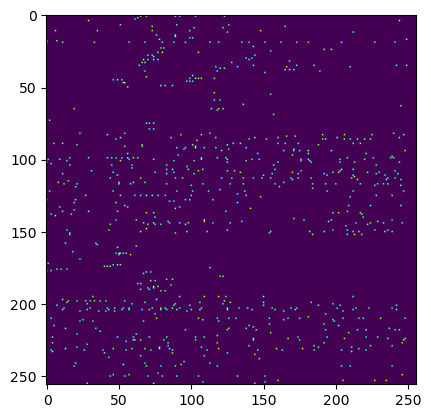

In [29]:
plt.imshow(allen_dataset[data_idx]['spikes'][0])

In [30]:
loss, pred, _ = model(torch.unsqueeze(allen_dataset[data_idx]['spikes'], dim=0).to(device))

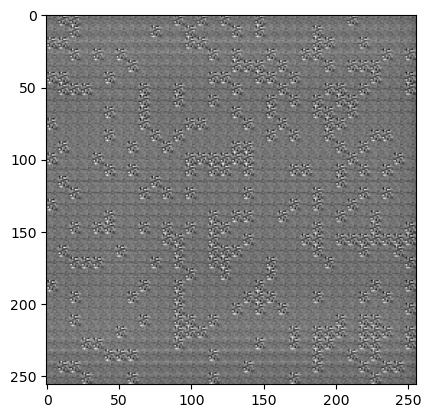

In [31]:
plt.imshow(model.unpatchify(pred)[0][0].cpu().detach().numpy(), cmap='gray')